In [1]:
%matplotlib inline
import itertools
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('bmh')
from numba import jit
from datetime import datetime, timedelta
from ipywidgets import FloatProgress
from IPython.display import display
import cmocean
# library for coordinate transformations
import pyproj
# Map plotting
from mpl_toolkits.basemap import Basemap
from glob import glob
from time import time
from scipy.spatial import KDTree

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

/Users/nordam/anaconda/lib/python3.5/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
def gauss(X0, sigmax, sigmay, theta, Xgrid):
    A = 1/(2*np.pi*sigmax*sigmay)
    a = (np.cos(theta)**2) / (2*sigmax**2) + (np.sin(theta)**2) / (2*sigmay**2)
    b = (-np.sin(2*theta)) / (4*sigmax**2) + ( np.sin(2*theta)) / (4*sigmay**2)
    c = (np.sin(theta)**2) / (2*sigmax**2) + (np.cos(theta)**2) / (2*sigmay**2)
    return A*np.exp(-(a*(Xgrid[0,:]-X0[0])**2 + 2*b*(Xgrid[0,:]-X0[0])*(Xgrid[1,:]-X0[1]) + c*(Xgrid[1,:]-X0[1])**2))

In [60]:
# Load some particle data
# The release location is at the origin
# The particles are released over 48 hours
# Simulation duration is 144 hours (6 days)

# The layout of X is (particles, xy, time)
X  = np.load('../data/particle_positions.npy')[]
Np = X.shape[0]
print(X.shape)

(5000, 2, 145)


In [43]:
Nx = 1501
Ny =  501

# Define a grid that covers all the particles
# Get extent of particle cloud, add some buffer, round to nearest 1000
buf = 5000
xmin = np.floor((np.amin(X[:,0,:]) - buf)/1000)*1000
xmax = np.ceil( (np.amax(X[:,0,:]) + buf)/1000)*1000
ymin = np.floor((np.amin(X[:,1,:]) - buf)/1000)*1000
ymax = np.ceil( (np.amax(X[:,1,:]) + buf)/1000)*1000
xc = np.linspace(xmin, xmax, Nx)
yc = np.linspace(ymin, ymax, Ny)
dx = xc[1] - xc[0]
dy = yc[1] - yc[0]
Xgrid = np.array(np.meshgrid(xc, yc))

print('Grid resolution: %s x %s' % (dx, dy))

Grid resolution: 110.0 x 106.0


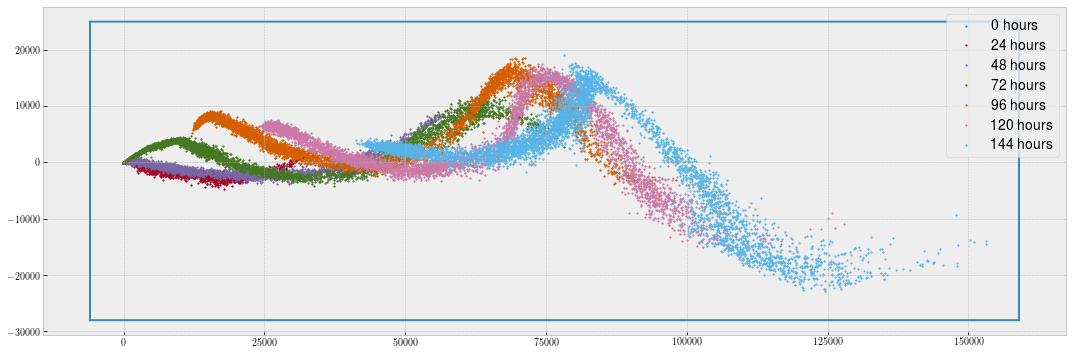

In [59]:
# Plot daily snapshots of particles
# to get an idea of the extent

fig = plt.figure(figsize = (15,6))
ax = fig.add_subplot(111, aspect = 'equal')
for i in range(0, 145, 24):
    plt.scatter(X[:,0,i], X[:,1,i], s = 10, marker = '.',label= '%s hours' % i)
    
# Add grid outline to verify
l, = plt.plot(Xgrid[0,0,:], Xgrid[1,0,:])
plt.plot(Xgrid[0,:,-1], Xgrid[1,:,-1], c = l.get_color())
plt.plot(Xgrid[0,-1,:], Xgrid[1,-1,:], c = l.get_color())
plt.plot(Xgrid[0,:,0], Xgrid[1,:,0], c = l.get_color())
plt.legend(loc = 'upper right', fontsize = 14)
plt.tight_layout()

In [132]:
# Select timestep
it = -1
# Number of nearest neighbours to base kernel on
N  = 200

# Build kd-tree
tree = KDTree(X[:,:,it])
# Initialise concentration grid
concgrid = np.zeros((Nx, Ny))

for n in range(Np):
    X0 = X[n,:,it]
    # Get nearest neighbours from tree (and their distances)
    dists, inds = tree.query(X0, k = N)
    # Index X with return from tree
    closest = X[inds,:,it]
    # Rescale relatively to X0
    rescaled = closest - X0.reshape(1,2)
    # Get right singular vectors, singular values, left singular vectors
    U,S,V = np.linalg.svd(rescaled.T)
    # Scale factor in standard deviations
    c = 0.1
    # Calculate standard deviations and angle
    sigmax = c*S[0]
    sigmay = c*S[1]
    theta = -np.arctan2(U[0,1], U[0,0])
    # Get index of closest cell in concentrationgrid
    ix = int((X0[0] - xc[0])/dx)
    iy = int((X0[1] - yc[0])/dy)
    # Calculate number of cells needed to capture 2 sigmas
    w = 2*int(max(sigmax, sigmay)/min(dx, dy))
    concgrid[ix-w:ix+w+1, iy-w:iy+w+1] += gauss(X0, sigmax, sigmay, theta, Xgrid[:, iy-w:iy+w+1,ix-w:ix+w+1]).T

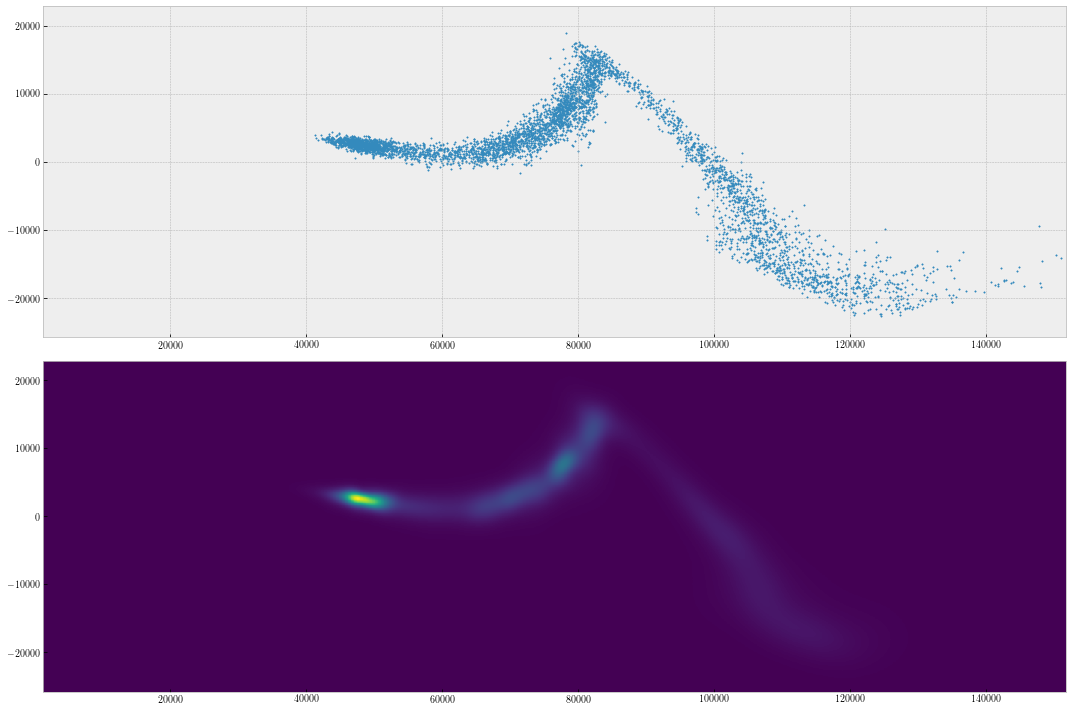

In [133]:
fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(211, aspect = 'equal')
ax2 = fig.add_subplot(212, aspect = 'equal', sharex = ax1, sharey = ax1)

ax1.scatter(X[:,0,it], X[:,1,it], s = 2)
ax2.pcolormesh(xc, yc, concgrid.T)
plt.tight_layout()

[55720.2857118  14155.89243853] [[-0.79914827  0.60113396]
 [ 0.60113396  0.79914827]]
2.4966733344558767


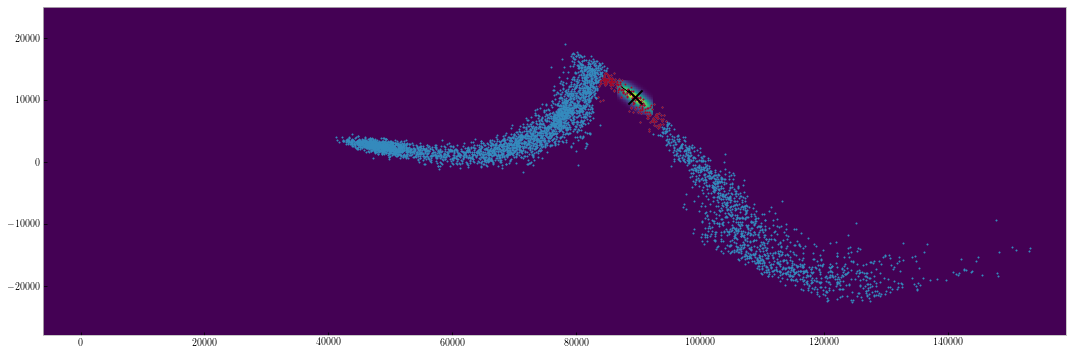

In [112]:
# some debug plotting happened below

# Select timestep
it = -1
# Number of nearest neighbours to base kernel on
N  = 200

# Build kd-tree
tree = KDTree(X[:,:,it])
# Initialise concentration grid
concgrid = np.zeros((Nx, Ny))

#for n in range(Np):
for n in [1550]:
    X0 = X[n,:,it]
    # Get nearest neighbours from tree (and their distances)
    dists, inds = tree.query(X0, k = N)
    # Index X with return from tree
    closest = X[inds,:,it]
    # Rescale relatively to X0
    rescaled = closest - X0.reshape(1,2)
    # Get right singular vectors, singular values, left singular vectors
    U,S,V = np.linalg.svd(rescaled.T)
    # Scale factor in standard deviations
    c = 5e-2
    # Calculate standard deviations and angle
    sigmax = c*S[0]
    sigmay = c*S[1]
    theta = -np.arctan2(U[0,1], U[0,0])
    # Get index of closest cell in concentrationgrid
    ix = int((X0[0] - xc[0])/dx)
    iy = int((X0[1] - yc[0])/dy)
    # Calculate number of cells needed to capture 3 sigmas
    w = int(max(sigmax, sigmay)/min(dx, dy))
    concgrid[ix-w:ix+w+1, iy-w:iy+w+1] += gauss(X0, sigmax, sigmay, theta, Xgrid[:, iy-w:iy+w+1,ix-w:ix+w+1]).T


fig = plt.figure(figsize = (15,6))
ax = fig.add_subplot(111, aspect = 'equal')

plt.pcolormesh(xc, yc, concgrid.T, zorder = 0)
plt.scatter(X[:,0,it], X[:,1,it], s = 2)
plt.scatter(closest[:,0], closest[:,1], s = 2)
plt.scatter(X0[0], X0[1], marker = 'x', s = 200, c = 'k')
plt.arrow(X0[0], X0[1], c*S[0]*U[0,0], c*S[0]*U[0,1], color = 'k')
plt.tight_layout()
print(S, U)
print(np.arctan2(U[0,1], U[0,0]))